In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.metrics import LogLoss


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler

import sys




def preprocess_data(filename):
    data = pd.read_csv(filename)
    
    def separate_features(dataframe):
        categorical_features = []
        continuous_features = []

        for column in dataframe.columns:
            if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
                categorical_features.append(column)
            elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
                continuous_features.append(column)
            else:
                print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

        return categorical_features, continuous_features




    data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
    leakage_features = [
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        'last_fico_range_high',
        'last_fico_range_low',
        'id',
        'url',
        'emp_title',
        'title'
    ]

    # Drop the leakage features
    data = data.drop(leakage_features, axis=1)

    # Calculate the percentage of missing values for each feature
    missing_values = data.isnull().sum() / len(data) * 100

    # Identify columns with more than 90% missing values
    columns_to_drop = missing_values[missing_values > 90].index

    # Drop the identified columns
    data = data.drop(columns_to_drop, axis=1)

    categorical_features, continuous_features = separate_features(data)
    categorical_features.remove('loan_status')
    
    
    # fill numeric NAs with median
    #median_values = data[continuous_features].median() 
    #data[continuous_features] = data[continuous_features].fillna(median_values)
    data[continuous_features] = data[continuous_features].fillna(-1)
    
    
    # Fill categorical NAs with "missing" and convert all elements to strings
    data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

    
    
    data_not_encoded = data.copy()
    
    
    
    for feature in categorical_features:
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    


    # Preprocess loan status labels with custom encoding
    custom_encoding = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
    
    }
    data['loan_status'] = data['loan_status'].replace(custom_encoding)
    
    
    
    
    return data, data_not_encoded

#a=torch.cuda.FloatTensor()
display(torch.cuda.is_available())
#sys.exit()

filename = 'accepted_2007_to_2018Q4.csv'
df, data_not_encoded = preprocess_data(filename)

X = df.drop(columns=['loan_status']).values
y = df['loan_status'].values

# model path
model_path = 'tabnet_model.pth.zip'

# Load the model
tabnet_model = TabNetClassifier()
tabnet_model.load_model(model_path)

#Split the dataset
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Create an array that holds the original indices
original_indices = df.index.values

#Split the dataset, but also split the original_indices array in the same way
X_train_val, X_test, y_train_val, y_test, original_indices_train_val, original_indices_test = train_test_split(X, y, original_indices, test_size=0.2, random_state=42, stratify=y)

# Further split the training set and the indices
X_train, X_val, y_train, y_val, original_indices_train, original_indices_val = train_test_split(X_train_val, y_train_val, original_indices_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


#Undersample the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

y_val_pred_proba = tabnet_model.predict_proba(X_val)



True

C:\Users\Carlo Alberto\AppData\Local\Temp\ipykernel_15728\3354317031.py:29: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [6]:
print(original_indices_test[1:10])

[1279983  222290 1266613 1903508   36267     449 1327630 2206232 1258475]


In [11]:
feature_importances = M_explain.sum(axis=0)

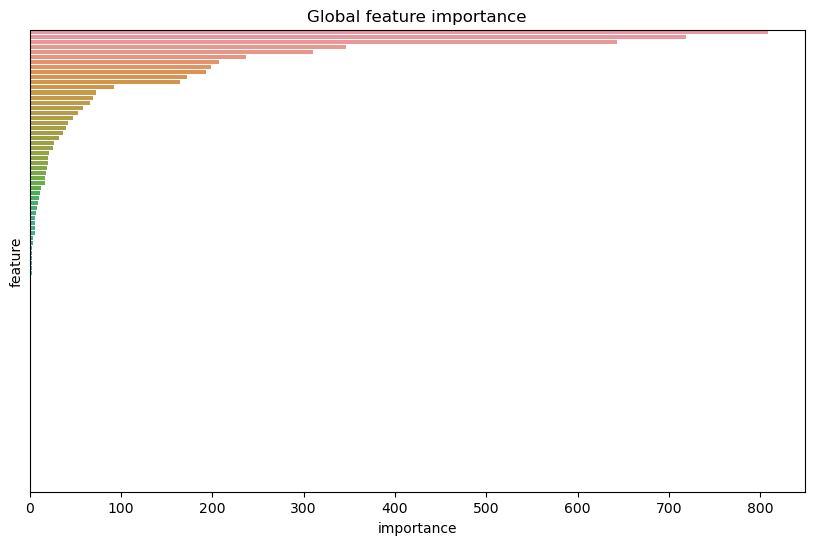

In [2]:
# First, we get the feature names from your DataFrame
feature_names = df.drop(columns=['loan_status']).columns

# We assume that you have computed feature_importances as in the previous example
M_explain, masks = tabnet_model.explain(X_test)
feature_importances = M_explain.sum(axis=0)/1000

# Then we create a DataFrame that we'll use for plotting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Finally, we create the plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', orient='h')

# Remove the y-axis labels
plt.yticks([], [])


plt.title('Global feature importance')
plt.show()

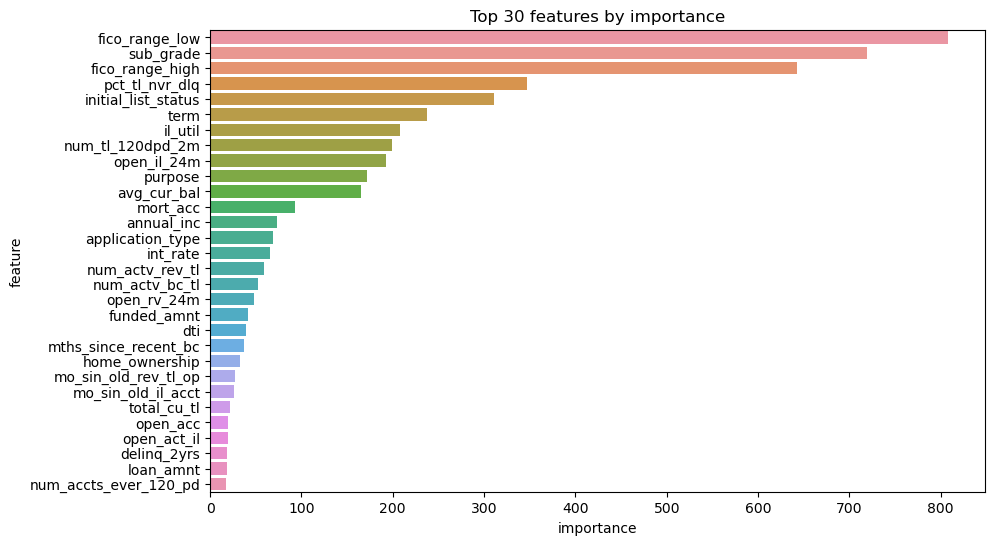

In [18]:
top_N = 30
top_features = importance_df.iloc[:top_N]

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature', orient='h')
plt.title(f'Top {top_N} features by importance')
plt.show()

In [9]:
# Get the top 30 features
top_30_features = importance_df.iloc[:30]

# Print the names and importance scores of the top 30 features
for idx, row in top_30_features.iterrows():
    print(f"Feature: {row['feature']}, Importance: {row['importance']}")

Feature: fico_range_low, Importance: 808.1856423497281
Feature: sub_grade, Importance: 719.1952671698053
Feature: fico_range_high, Importance: 642.6929642720611
Feature: pct_tl_nvr_dlq, Importance: 346.61273469505045
Feature: initial_list_status, Importance: 310.3836613619503
Feature: term, Importance: 237.4475225411986
Feature: il_util, Importance: 207.76332289116272
Feature: num_tl_120dpd_2m, Importance: 198.80702245395844
Feature: open_il_24m, Importance: 192.792654514545
Feature: purpose, Importance: 172.14210923127965
Feature: avg_cur_bal, Importance: 165.199319837075
Feature: mort_acc, Importance: 92.70300801768131
Feature: annual_inc, Importance: 72.69294735750914
Feature: application_type, Importance: 69.17824382651096
Feature: int_rate, Importance: 65.86576762478113
Feature: num_actv_rev_tl, Importance: 58.9235838089611
Feature: num_actv_bc_tl, Importance: 52.562104691617
Feature: open_rv_24m, Importance: 47.909769001955226
Feature: funded_amnt, Importance: 41.89827895441306
F

In [5]:
type(masks)

dict

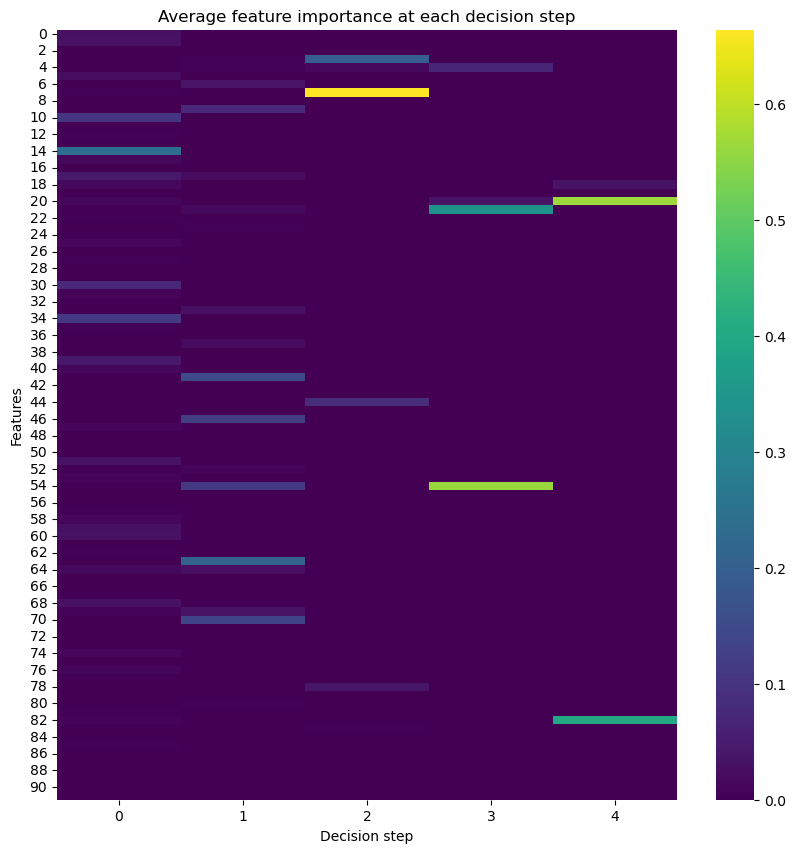

In [6]:
# Compute the average importance of each feature at each decision step
avg_masks = {k: np.mean(v, axis=0) for k, v in masks.items()}

# Create a DataFrame for plotting
avg_masks_df = pd.DataFrame(avg_masks)

# Plot the average importance of each feature at each decision step
plt.figure(figsize=(10, 10))
sns.heatmap(avg_masks_df, cmap='viridis')
plt.title('Average feature importance at each decision step')
plt.ylabel('Features')
plt.xlabel('Decision step')
plt.show()

In [8]:
# For each decision step, get the indices of the top 10 features
top_10_indices = {k: np.argsort(v)[-10:] for k, v in avg_masks.items()}

# Print the top 10 features for each decision step
for step, indices in top_10_indices.items():
    print(f'Decision step {step}:')
    for idx in reversed(indices):
        print(f' - Feature: {feature_names[idx]}, Importance: {avg_masks[step][idx]}')
    print()

Decision step 0:
 - Feature: purpose, Importance: 0.23388466559353382
 - Feature: application_type, Importance: 0.11395995513718735
 - Feature: annual_inc, Importance: 0.10279610399497417
 - Feature: initial_list_status, Importance: 0.07437558363888358
 - Feature: open_act_il, Importance: 0.043487820190304366
 - Feature: dti, Importance: 0.042157103251364826
 - Feature: mo_sin_old_rev_tl_op, Importance: 0.031061137829834974
 - Feature: funded_amnt, Importance: 0.030130202303939903
 - Feature: total_cu_tl, Importance: 0.028998973598231365
 - Feature: num_accts_ever_120_pd, Importance: 0.0276883825162435

Decision step 1:
 - Feature: mort_acc, Importance: 0.20919319787519408
 - Feature: open_il_24m, Importance: 0.14876375240876177
 - Feature: num_actv_rev_tl, Importance: 0.13698082818260135
 - Feature: open_rv_24m, Importance: 0.11918210132355084
 - Feature: avg_cur_bal, Importance: 0.11096884432743288
 - Feature: home_ownership, Importance: 0.07697885621476179
 - Feature: grade, Importa

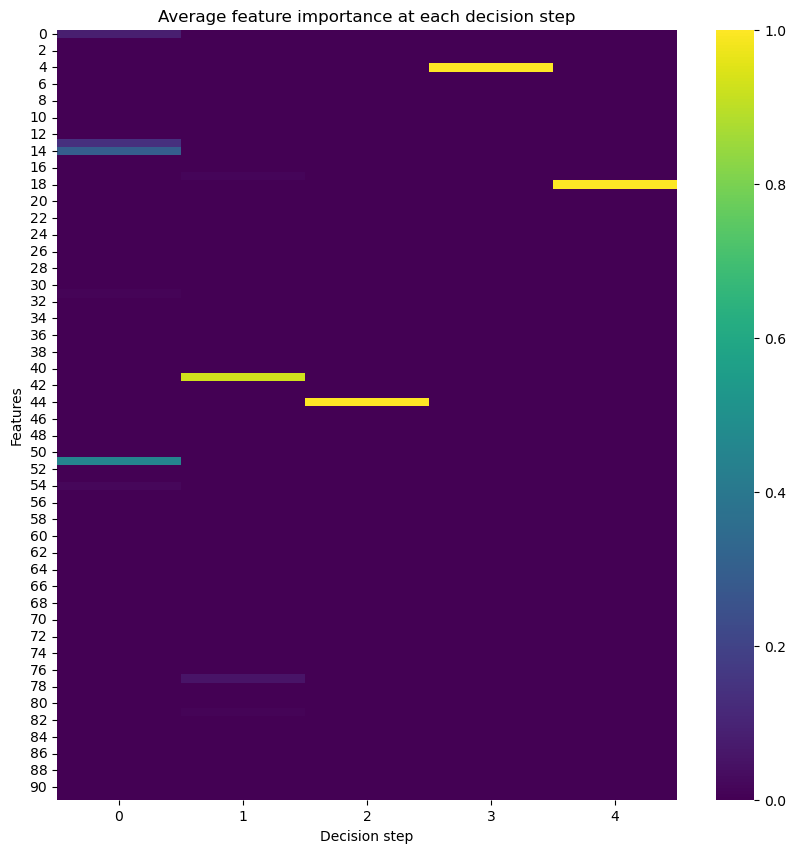

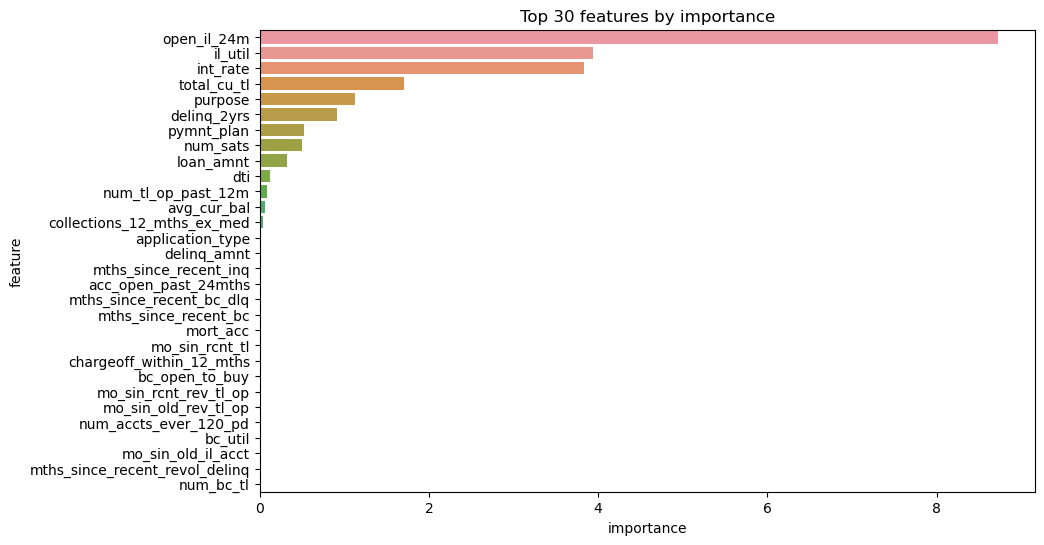

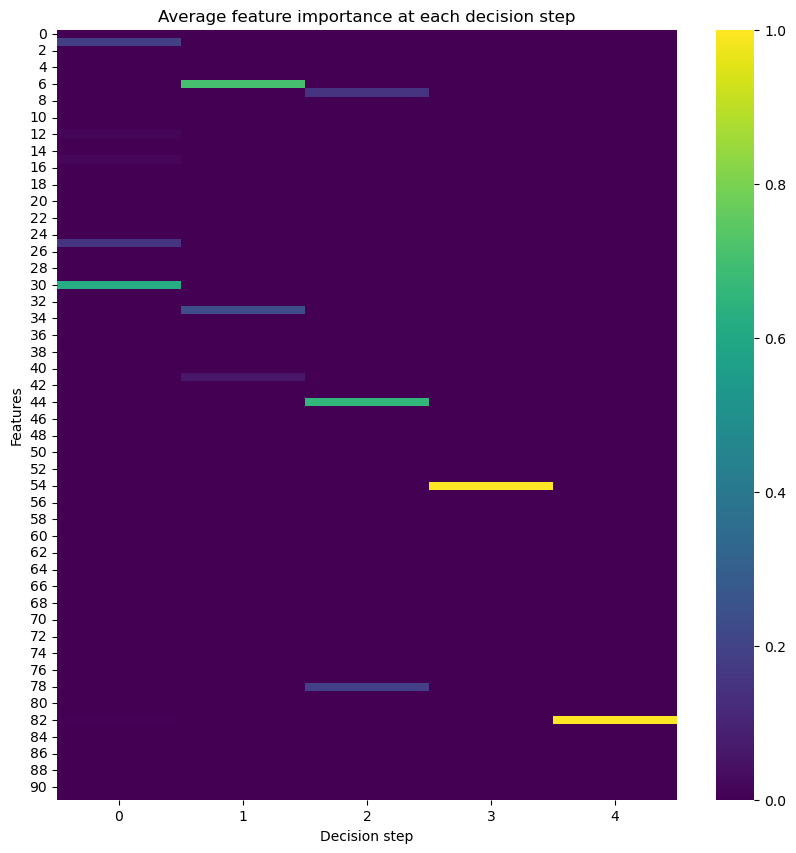

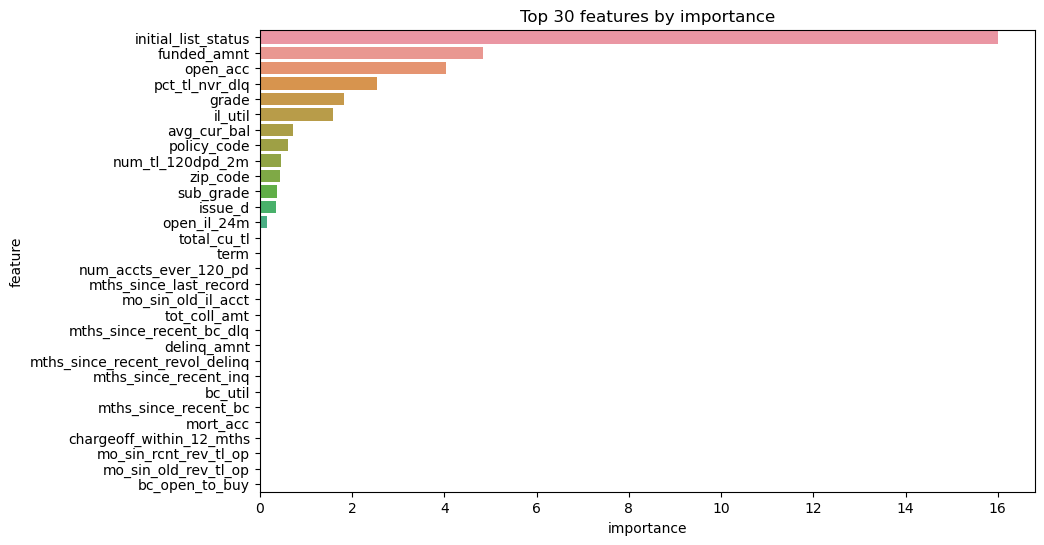

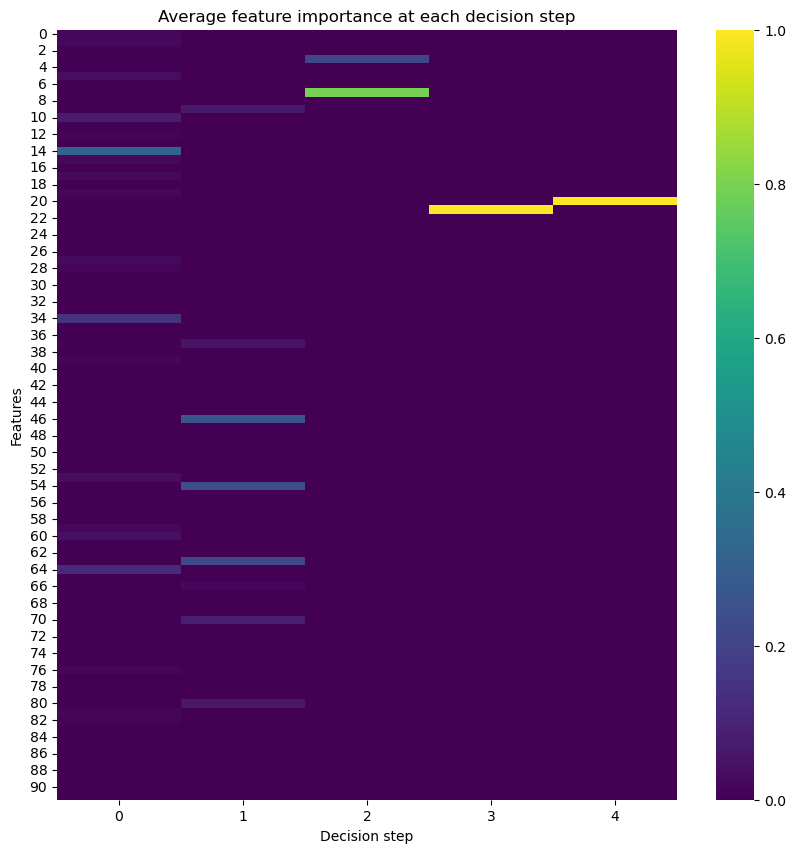

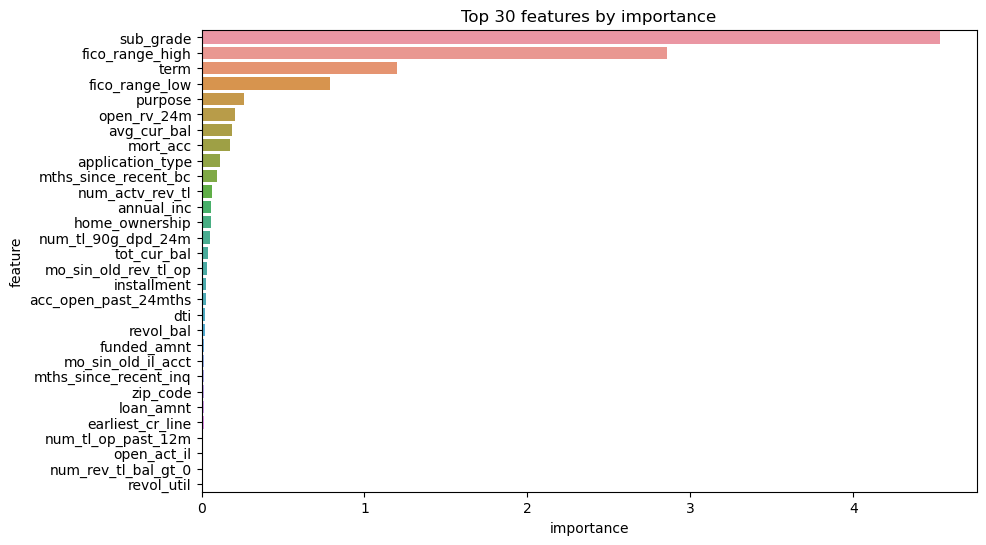

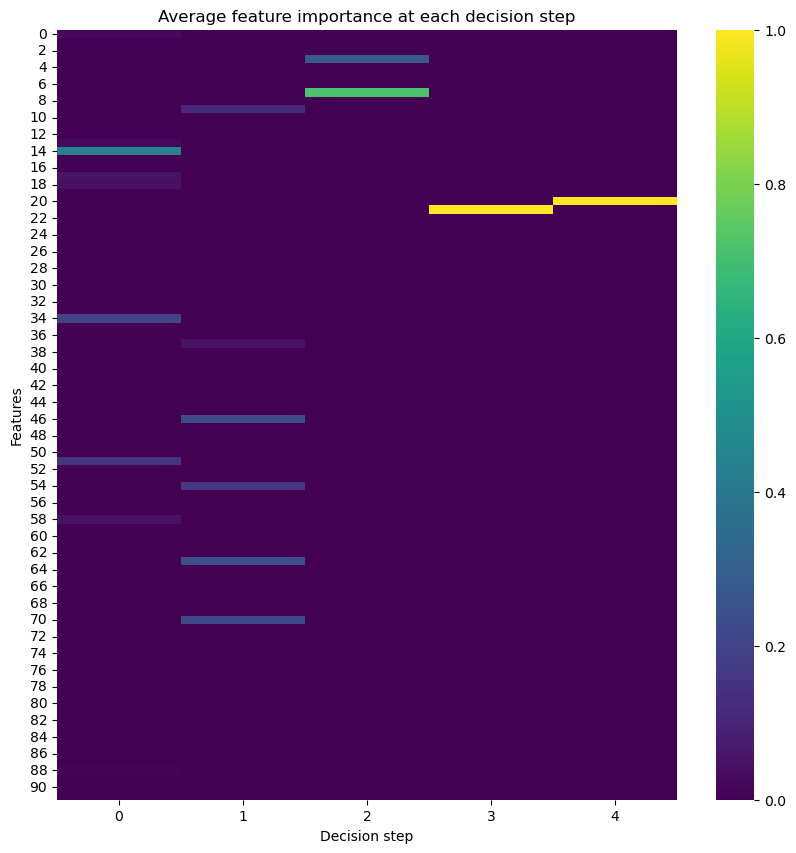

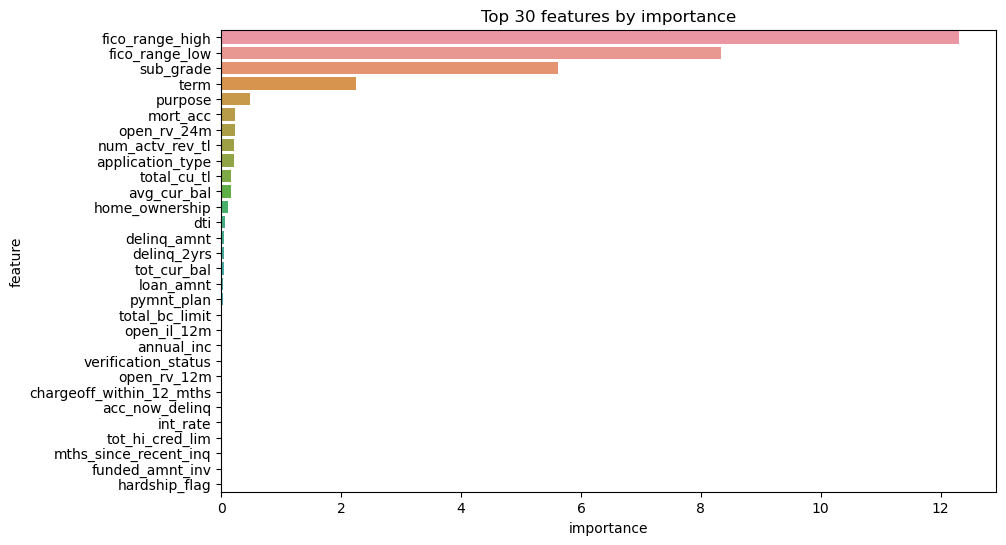

In [20]:
def plot_importances_for_sample(sample, feature_names, top_N=30):
    # Extract the importances of all features for this sample
    M_explain, masks = tabnet_model.explain(sample.reshape(1, -1))

    # Compute the average importance of each feature at each decision step
    avg_masks = {k: np.mean(v, axis=0) for k, v in masks.items()}

    # Create a DataFrame for plotting
    avg_masks_df = pd.DataFrame(avg_masks)

    # Plot the average importance of each feature at each decision step
    plt.figure(figsize=(10, 10))
    sns.heatmap(avg_masks_df, cmap='viridis')
    plt.title('Average feature importance at each decision step')
    plt.ylabel('Features')
    plt.xlabel('Decision step')
    plt.show()

    # Then we create a DataFrame that we'll use for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': M_explain.squeeze()
    })
    
    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    top_features = importance_df.iloc[:top_N]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_features, x='importance', y='feature', orient='h')
    plt.title(f'Top {top_N} features by importance')
    plt.show()


# Get the predictions for the test set
y_pred_proba = tabnet_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get indices of correctly predicted positive and negative samples
correct_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
correct_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select 2 positive and 2 negative samples
selected_positive_indices = np.random.choice(correct_positive_indices, 2, replace=False)
selected_negative_indices = np.random.choice(correct_negative_indices, 2, replace=False)

# Get the corresponding samples from X_test
positive_samples = X_test[selected_positive_indices]
negative_samples = X_test[selected_negative_indices]

feature_names = df.drop(columns=['loan_status']).columns

# Plot importances for each sample
for sample in np.concatenate([positive_samples, negative_samples]):
    plot_importances_for_sample(sample, feature_names)


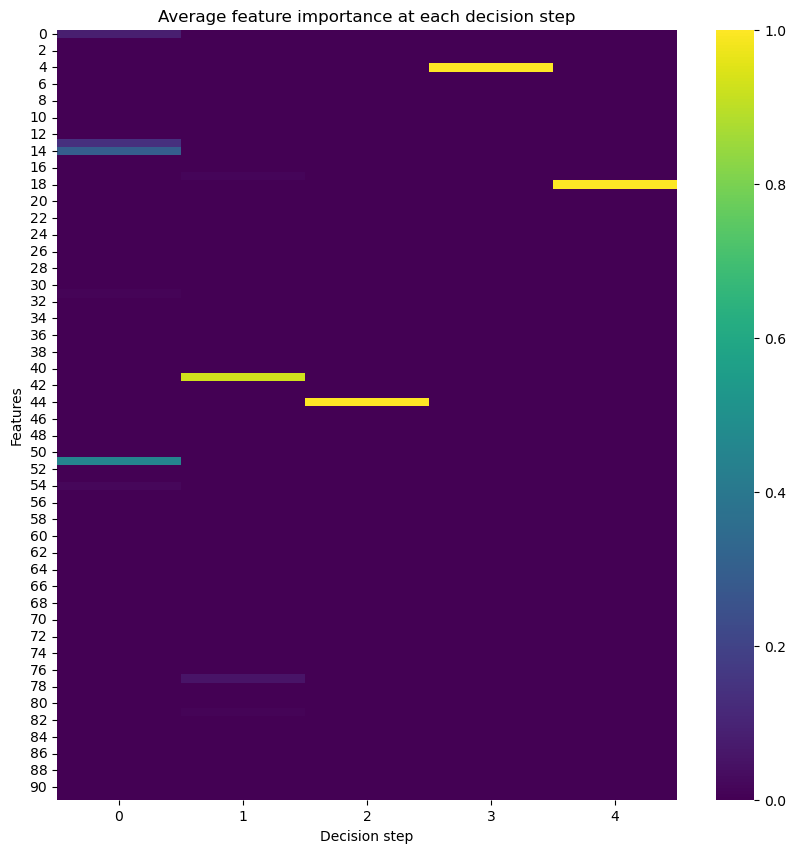

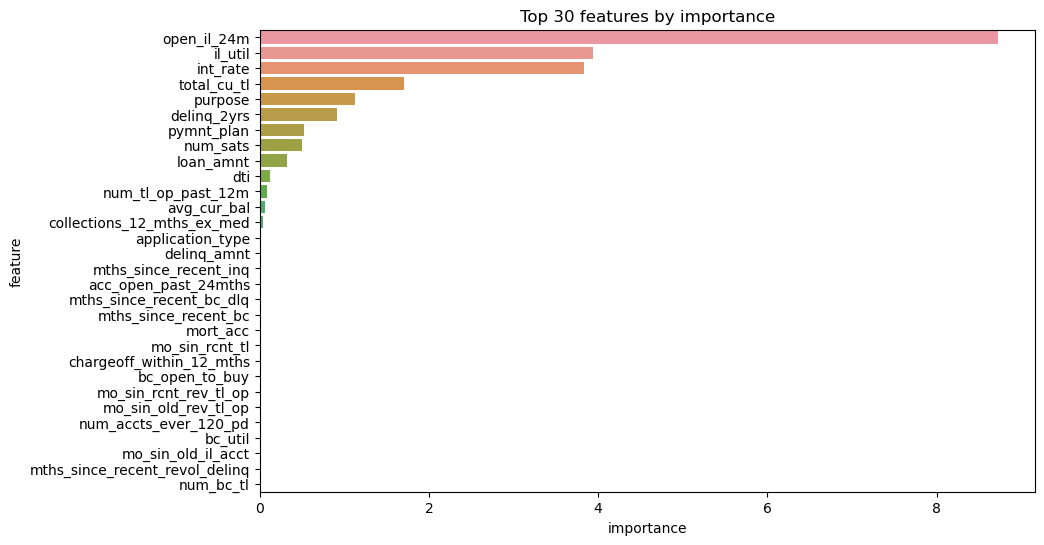


Top 10 feature importances and their values for this sample:
open_il_24m (importance: 8.72354793548584): 2.0
il_util (importance: 3.9428253173828125): 43.0
int_rate (importance: 3.831860303878784): 20.39
total_cu_tl (importance: 1.7098702192306519): 6.0
purpose (importance: 1.1240240335464478): other
delinq_2yrs (importance: 0.916214108467102): 1.0
pymnt_plan (importance: 0.5257789492607117): n
num_sats (importance: 0.4943869113922119): 26.0
loan_amnt (importance: 0.3207598030567169): 24000.0
dti (importance: 0.11634839326143265): 26.91


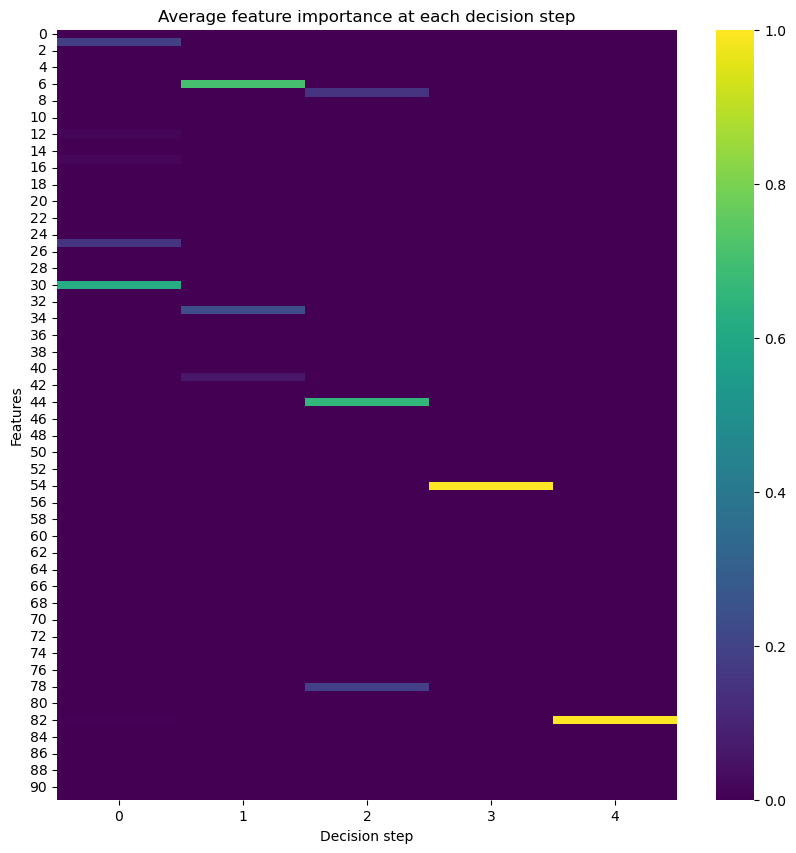

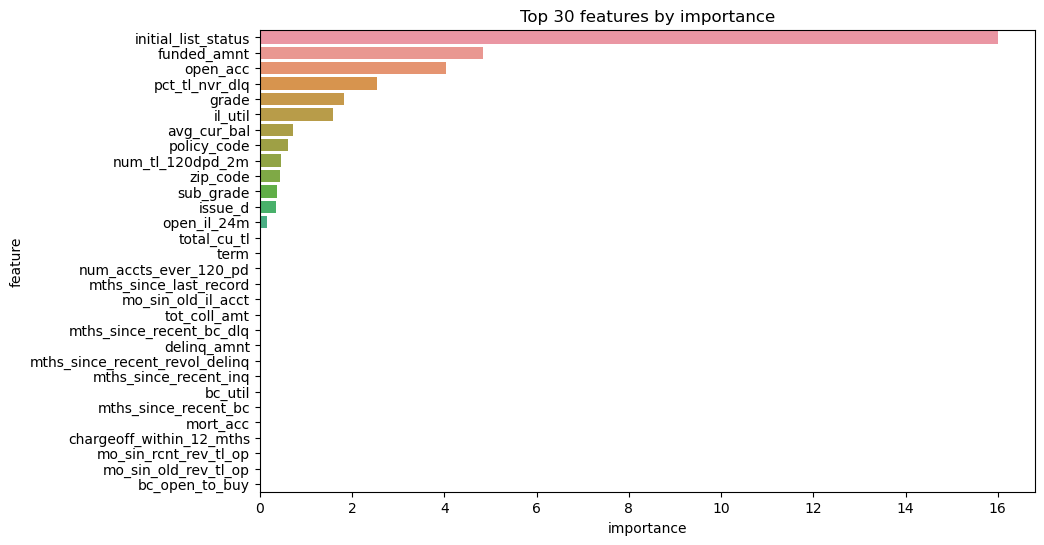


Top 10 feature importances and their values for this sample:
initial_list_status (importance: 16.002349853515625): w
funded_amnt (importance: 4.831820964813232): 24000.0
open_acc (importance: 4.042287349700928): 13.0
pct_tl_nvr_dlq (importance: 2.5510151386260986): 92.9
grade (importance: 1.81815505027771): E
il_util (importance: 1.589782476425171): -1.0
avg_cur_bal (importance: 0.7098525762557983): 3888.0
policy_code (importance: 0.6064226627349854): 1.0
num_tl_120dpd_2m (importance: 0.4558146595954895): 0.0
zip_code (importance: 0.4346126914024353): 112xx


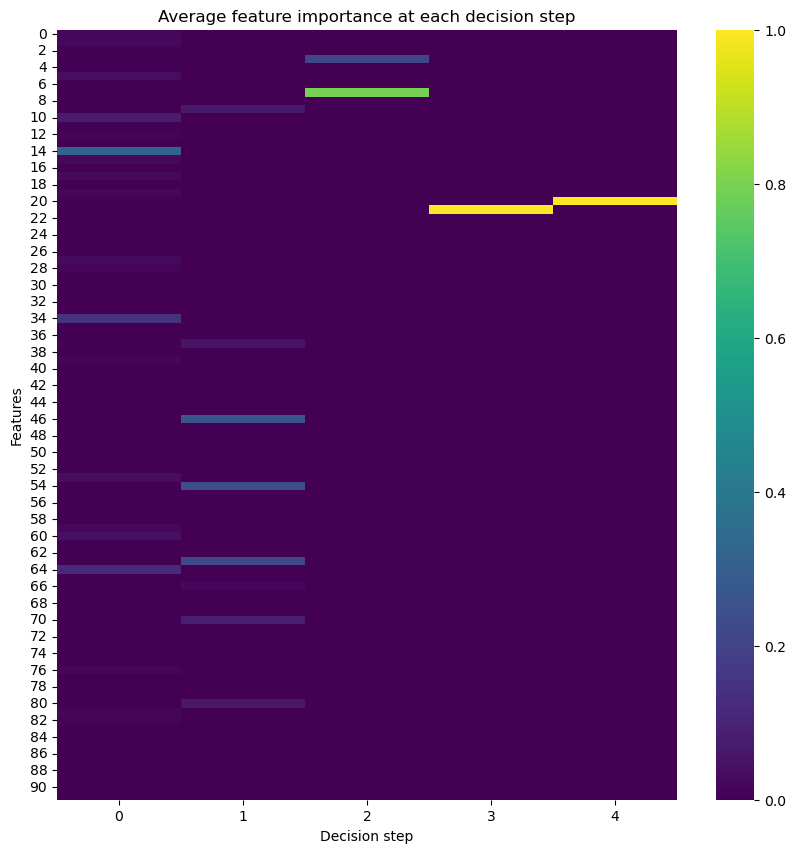

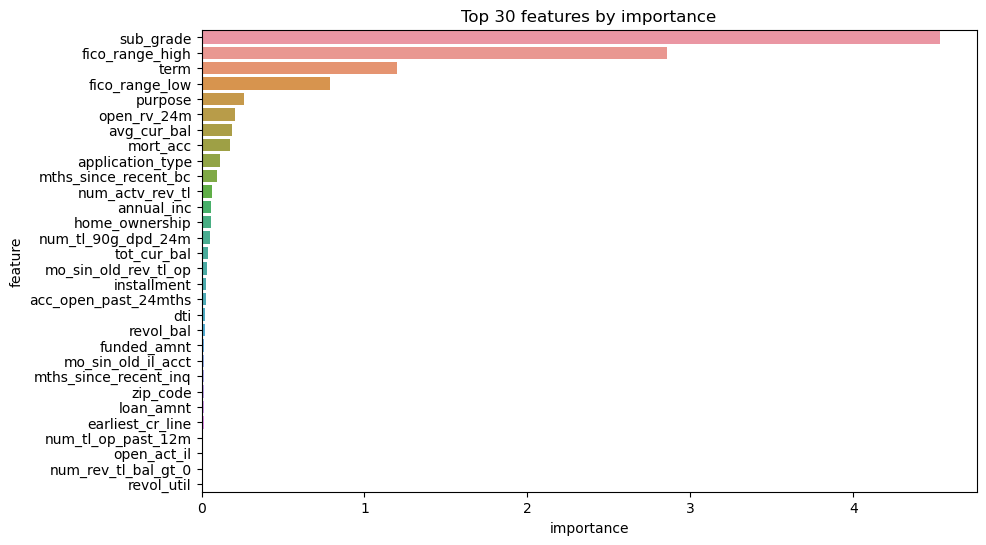


Top 10 feature importances and their values for this sample:
sub_grade (importance: 4.529164791107178): C5
fico_range_high (importance: 2.85548734664917): 674.0
term (importance: 1.1988778114318848):  60 months
fico_range_low (importance: 0.7891550064086914): 670.0
purpose (importance: 0.25973621010780334): debt_consolidation
open_rv_24m (importance: 0.20677466690540314): -1.0
avg_cur_bal (importance: 0.18975253403186798): 27360.0
mort_acc (importance: 0.1768920123577118): 2.0
application_type (importance: 0.11529388278722763): Individual
mths_since_recent_bc (importance: 0.094698466360569): 120.0


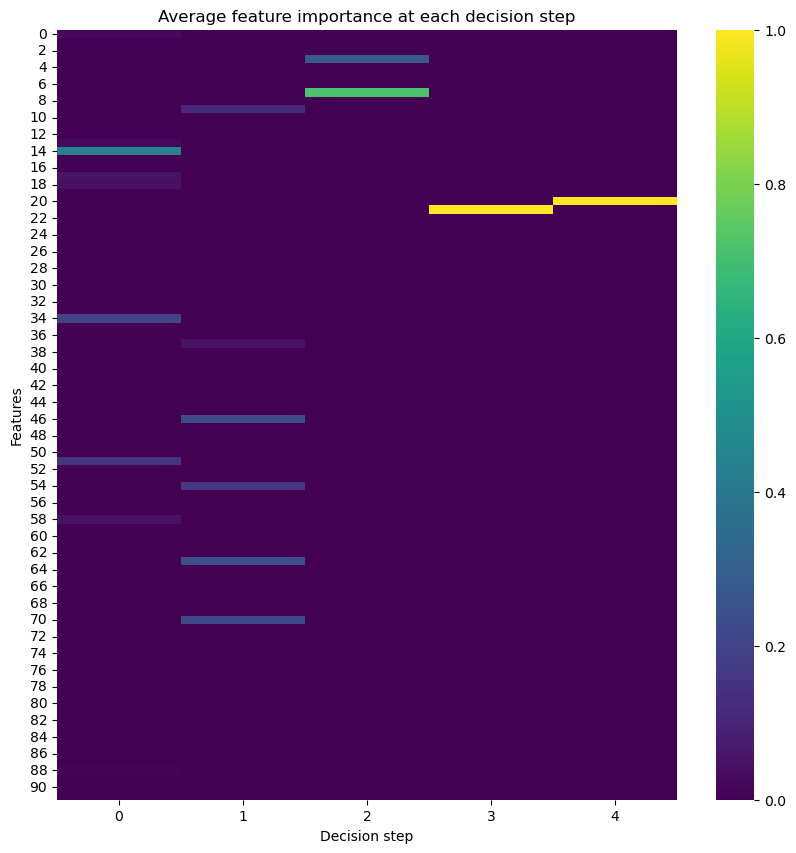

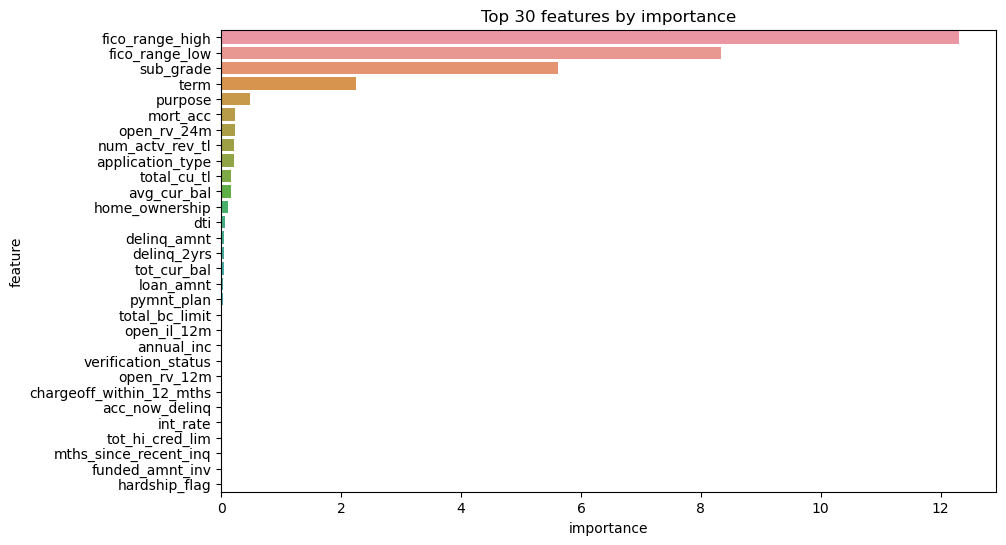


Top 10 feature importances and their values for this sample:
fico_range_high (importance: 12.315132141113281): 719.0
fico_range_low (importance: 8.33153247833252): 715.0
sub_grade (importance: 5.616199970245361): C2
term (importance: 2.2420623302459717):  60 months
purpose (importance: 0.4714605510234833): debt_consolidation
mort_acc (importance: 0.2318345010280609): 3.0
open_rv_24m (importance: 0.22481714189052582): -1.0
num_actv_rev_tl (importance: 0.21635234355926514): 8.0
application_type (importance: 0.2162570357322693): Individual
total_cu_tl (importance: 0.1638517528772354): -1.0


In [39]:
def plot_importances_for_sample(sample, feature_names, original_index, top_N=30):
    # Extract the importances of all features for this sample
    M_explain, masks = tabnet_model.explain(sample.reshape(1, -1))

    # Compute the average importance of each feature at each decision step
    avg_masks = {k: np.mean(v, axis=0) for k, v in masks.items()}

    # Create a DataFrame for plotting
    avg_masks_df = pd.DataFrame(avg_masks)

    # Plot the average importance of each feature at each decision step
    plt.figure(figsize=(10, 10))
    sns.heatmap(avg_masks_df, cmap='viridis')
    plt.title('Average feature importance at each decision step')
    plt.ylabel('Features')
    plt.xlabel('Decision step')
    plt.show()

    # Then we create a DataFrame that we'll use for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': M_explain.squeeze()
    })
    
    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    top_features = importance_df.iloc[:top_N]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_features, x='importance', y='feature', orient='h')
    plt.title(f'Top {top_N} features by importance')
    plt.show()

    # Print top 10 feature importances and corresponding feature values for this sample
    top_10_features = importance_df.iloc[:10]
    print("\nTop 10 feature importances and their values for this sample:")
    for _, row in top_10_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        feature_value = data_not_encoded.loc[original_index, feature]
        print(f"{feature} (importance: {importance}): {feature_value}")


# Get the predictions for the test set
y_pred_proba = tabnet_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get indices of correctly predicted positive and negative samples
correct_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
correct_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select 2 positive and 2 negative samples
selected_positive_indices = np.random.choice(correct_positive_indices, 2, replace=False)
selected_negative_indices = np.random.choice(correct_negative_indices, 2, replace=False)


# Combine selected indices
selected_indices = np.concatenate([selected_positive_indices, selected_negative_indices])

# Plot importances for each sample
for idx in selected_indices:
    original_index = original_indices_test[idx]
    sample = X_test[idx]
    plot_importances_for_sample(sample, feature_names, original_index)


In [14]:
M_explain, masks = tabnet_model.explain(sample.reshape(1, -1))


In [17]:
M_explain.shape
feature_names.shape

(92,)

In [12]:
masks.items()

dict_items([(0, array([[0.        , 0.01289065, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.15947703,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.57343739, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06387083, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.06853253, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 